In [1]:
from oLIMpus import analysis as a 
from oLIMpus import CoevalBox_LIM_analytical, CoevalBox_percell, CoevalBox_T21reionization, CoevalBox_percell, CoevalBox_LIM_analytical
from oLIMpus import get_T21_coefficients, Correlations, Power_Spectra
from oLIMpus import eor_colour, LIM_colour_1, LIM_colour_2,get_reio_field
from matplotlib.colors import LogNorm

import matplotlib.pyplot as plt 
import numpy as np 
from scipy.fft import fft, fft2, fftfreq

import powerbox as pb
from copy import copy 

import pickle
import os 

import matplotlib.animation as animation
plt.rcParams['animation.embed_limit'] = 100  # Set the embed limit to 100 MB
import os
from IPython.display import HTML
from scipy.interpolate import interp1d, RegularGridInterpolator

from tqdm import tqdm


## Set the run

1) Inputs for the oLIMpus run

In [2]:
ZMIN = 5.
RSD_MODE = 1
ClassyC = a.runclass(a.Cosmo_Parameters_Input(**a.CosmoParams_input_fid))


2) Run oLIMpus to store in a class all the properties for the line and for the 21cm correlations (deafault will take 25s).

For the fiducial case, we use a class that collects all the required quantities (this is defined in the analysis.py module). 

In [3]:
line_model = a.run_oLIMpus('OIII',LINE_MODEL = 'Yang24', _R = 2., shot_noise= True, quadratic_lognormal=True, astromodel=0, ZMIN=ZMIN, RSD_MODE=RSD_MODE)

/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:28: RuntimeWarning: divide by zero encountered in power
  L_line = 2. * N * dotM / ((dotM / SFR1)**(-alpha) + (dotM / SFR1)**beta)
/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:30: RuntimeWarning: divide by zero encountered in log10
  log10_L = np.log10(L_line)


3) The following function produces the boxes to study the anticorrelation. Its inputs are:
- z = redshift value
- Lbox = side of the box in Mpc
- Nbox = number of cells per side
- line model = the class containing the oLIMpus outputs for line and 21cm
- reionization_map_partial, ion_frac_withpartial = classes containing the ionization and bubble fields; they are computed for all z, hence it is recommended to run them outside the class to avoid redundancy that makes everything much longer
- ClassyC = CLASS output
- RSD = which RSD to use, 0 is without RSD while 1 is mu = 0.6, i.e. spherically averaged
- what = if "SFRDxH" computes the correlation between SFRD and xH, otherwise between T21 (with / without bubbles) and the line intensity (with/without shot noise)
- seed = random seed
- extralabel = string to be included in the output file more than the default ones
- save = whether to save the outputs (note that since each z outputs 2 or 4 boxes, storing all of them requires a lot of space); if previous runs were store, this flag allows to import their outputs, to fasten the computation

In [4]:
def get_boxes(z, Lbox, Nbox, line_model, reionization_map_partial, ion_frac_withpartial, ClassyC, RSD, what, seed=1605, extralabel='', save=True):

    box_slices = []    

    vmin = []
    vmax = []
    cmap = []
    title = []

    folder = './boxes_' + str(Lbox) + ',' + str(Nbox)
    if not os.path.exists(folder):
        os.makedirs(folder)

    filename_all_T21 = folder + '/T21_z' + str(round(z,1))+ '.pkl'
    if os.path.exists(filename_all_T21):
        with open(filename_all_T21, 'rb') as handle:
            box_T21 = pickle.load(handle)
    else:
        if reionization_map_partial is None:
            reionization_map_partial, ion_frac_withpartial = get_reio_field(line_model.zeus_coeff, line_model.zeus_corr, line_model.AP, line_model.CP, ClassyC, line_model.HMFcl, Lbox, Nbox, mass_weighted_xHII=True)
    
        box_T21 = CoevalBox_T21reionization(line_model.zeus_coeff, line_model.zeus_pk,z, reionization_map_partial, ion_frac_withpartial,Lbox,Nbox,seed=seed,one_slice=False)
        if save:
            with open(filename_all_T21, 'wb') as handle:
                pickle.dump(box_T21,handle)

    if what == 'SFRDxH':
        filename_all_SFRD = folder + '/SFRD_z' + str(round(z,1))+ '.pkl'
        if os.path.exists(filename_all_SFRD):
            with open(filename_all_SFRD, 'rb') as handle:
                box_SFRD = pickle.load(handle)
        else:
            box_SFRD = CoevalBox_percell(line_model.LIM_coeff,line_model.LIM_corr,line_model.LIM_pk,line_model.zeus_coeff, line_model.LP,line_model.AP,line_model.CP,line_model.HMFcl,z,line_model.LP._R,Lbox,Nbox,seed=seed,one_slice=False)
            if save:
                with open(filename_all_SFRD, 'wb') as handle:
                    pickle.dump(box_SFRD,handle)

    else:
        filename_all_line = folder + '/' + line_model.LP.LINE + extralabel + '_z' + str(round(z,1))+ '.pkl'
        if os.path.exists(filename_all_line):
            with open(filename_all_line, 'rb') as handle:
                box_line = pickle.load(handle)
        else:
            box_line = CoevalBox_LIM_analytical(line_model.LIM_coeff,line_model.LIM_corr,line_model.LIM_pk,line_model.LP,z,line_model.LP._R,Lbox,Nbox, RSD=RSD, get_density_box=True,seed=seed,one_slice=False)
            if save:
                with open(filename_all_line, 'wb') as handle:
                    pickle.dump(box_line,handle)

    xHavg = box_T21.xH_avg_map

    ### SFRD
    if what == 'SFRDxH':

        coeval_slice_SFRD = box_SFRD.SFRD_box
        coeval_slice_xHI = box_T21.xH_box

        box_slices.append(coeval_slice_SFRD)
        cmap.append('bwr')
        title.append(r'${\rm SFRD}\,[M_\odot/{\rm yr}/{\rm Mpc^3}]$')
        vmin.append(1e-3)
        vmax.append(1e0)

        ### XHI
        box_slices.append(coeval_slice_xHI)
        cmap.append('gray')
        title.append(r'$x_{\rm HI}$')
        vmin.append(0)
        vmax.append(1)

    else:
        coeval_slice_T21 = box_T21.T21_map
        coeval_slice_T21_temp = box_T21.T21_map_only
        coeval_slice_LIM_noiseless = box_line.Inu_box_noiseless_smooth
        coeval_slice_LIM = box_line.Inu_box_smooth

        ### T21
        box_slices.append(coeval_slice_T21)
        cmap.append(eor_colour)
        title.append(r'$T_{21}\,[{\rm mK}]$')
        vmin.append(-50)
        vmax.append(40)

        ### T21 only T
        box_slices.append(coeval_slice_T21_temp)
        cmap.append(eor_colour)
        title.append(r'$T_{21}\,[{\rm mK}]$')
        vmin.append(-50)
        vmax.append(40)

        ### LIM 1 
        if line_model.LP.LINE == 'OIII':
            LIM_colour=LIM_colour_1
        else:
            LIM_colour=LIM_colour_2

        box_slices.append(coeval_slice_LIM_noiseless)
        cmap.append(LIM_colour)
        title.append(r'$I_{\rm %s}\,[{\rm Jy/sr}]$'%line_model.LP.LINE) 
        vmin.append(0.)
        vmax.append(0.65*np.max(coeval_slice_LIM_noiseless))

        ### LIM2
        box_slices.append(coeval_slice_LIM)
        cmap.append(LIM_colour)
        title.append(r'$I_{\rm %s}+{\rm shot\, noise}$'%line_model.LP.LINE) 
        vmin.append(0.)
        vmax.append(0.65*np.max(coeval_slice_LIM))
        

    return box_slices, cmap, title, vmin, vmax, xHavg

4) The following function computes the Pearson coefficient between the two slices given as inputs

In [5]:
def Pearson(box_LIM, box_T21, foregrounds):

    cross_TLIM1 = np.corrcoef((box_T21.flatten()), box_LIM.flatten())[0, 1]
    if foregrounds:
        print('Foregrounds not yet implemented')

    return cross_TLIM1


We also introduce the cross characteristic function from arXiv:2210.14902

In [ ]:
# !!! TO FIX !!! 
def CC_estimator(box_LIM, box_T21, Nbin):

    bins_line = np.linspace(np.min(box_LIM), np.max(box_LIM), Nbin)
    bins_21 = np.linspace(np.min(box_T21), np.max(box_T21), Nbin)

    hist_line, bin_edges_line = np.histogram(box_LIM.flatten(), bins=bins_line)
    hist_21cm, bin_edges_21 = np.histogram(box_T21.flatten(), bins=bins_21)

    hist_cross, _, _ = np.histogram2d(box_LIM.flatten(), box_T21.flatten(), bins=[bins_line, bins_21])
    
    FFT_hist_line = fft(hist_line)
    FFT_hist_21cm = fft(hist_21cm)
    FFT_hist_cross= fft2(hist_cross)
    #FFT_hist_cross_shifted = fftshift(hist2d_fft)

    # Compute bin centers and bin width
    bin_centers_line = 0.5 * (bin_edges_line[:-1] + bin_edges_line[1:])
    dx_line = bin_centers_line[1] - bin_centers_line[0]    # bin spacing Δx
    bin_conj_line = fftfreq(len(hist_line), d=dx_line)        # units: 1 / [units of x]
    
    bin_centers_21 = 0.5 * (bin_edges_21[:-1] + bin_edges_21[1:])
    dx_21 = bin_centers_21[1] - bin_centers_21[0]    # bin spacing Δx
    bin_conj_21 = fftfreq(len(hist_21cm), d=dx_21)        # units: 1 / [units of x]
    
    R = -1. + FFT_hist_cross / FFT_hist_line / FFT_hist_21cm
    R *= len(box_LIM)**3

    return R, bin_conj_line, bin_conj_21

5) The following function computes the power spectra and the 2 point cross coefficient between the two slices given as inputs

In [7]:
def r_cross(box_LIM, box_T21, Lbox, k_bins, foregrounds):

    if foregrounds:
        print('Foregrounds not yet implemented')

    use_pk_cross, k_cross = pb.get_power(
    deltax = box_T21,
    boxlength= Lbox,
    deltax2 = box_LIM,
    bins = k_bins
    )

    use_pk_auto_21, _ = pb.get_power(
    deltax = box_T21,
    boxlength= Lbox,
    bins = k_bins
    )

    use_pk_auto_line, _ = pb.get_power(
    boxlength= Lbox,
    deltax = box_LIM,
    bins = k_bins
    )

    r = use_pk_cross/np.sqrt(use_pk_auto_line*use_pk_auto_21)

    return r, k_cross, use_pk_cross, use_pk_auto_21, use_pk_auto_line

6) Define the default quantities for the run 

In [8]:
Lbox_fid = 300 # box side Mpc
Nbox_fid = 150 # number of cells per side
seed = 3 # random seed

zvals = np.logspace(np.log10(line_model.zeus_coeff.zintegral[0]), np.log10(line_model.zeus_coeff.zintegral[-1]),50) # z array 
k_bins = np.logspace(np.log10(2*np.pi/Lbox_fid),np.log10(2*np.pi/Lbox_fid*Nbox_fid),10) # k array 

7) Run the ionization and bubble field for all redshifts (default will take 1m and 10s)

In [9]:
reionization_map_partial, ion_frac_withpartial = get_reio_field(line_model.zeus_coeff, line_model.zeus_corr, line_model.AP, line_model.CP, ClassyC, line_model.HMFcl, Lbox_fid, Nbox_fid, mass_weighted_xHII=True, seed=seed)

 60%|██████    | 6/10 [00:00<00:00,  6.23it/s]


SUCCESS: BMF converged in 6 iterations.


100%|██████████| 99/99 [00:28<00:00,  3.43it/s]


## Get correlation between SFRD and xH

Default will take around 15m

In [45]:
r_SFRDxH = np.zeros((len(zvals),len(k_bins)-1))
P_SFRDxH = np.zeros(len(zvals))
xHvals = np.zeros(len(zvals))
slice_SFRD = []
slice_xH = []

for i in tqdm(range(len(zvals))):

    boxes, cmap, title, vmin, vmax, xHavg = get_boxes(zvals[i], Lbox_fid, Nbox_fid, line_model, reionization_map_partial, ion_frac_withpartial, ClassyC, RSD_MODE, 'SFRDxH', seed, extralabel='', save=False)

    slice_SFRD.append(boxes[0])
    slice_xH.append(boxes[1])

    temp = r_cross(slice_SFRD[i], slice_xH[i], Lbox_fid, k_bins, foregrounds=False)
    r_SFRDxH[i,:] = temp[0]
    P_SFRDxH[i] = Pearson(slice_SFRD[i], slice_xH[i], foregrounds=False)

    xHvals[i] = xHavg

  0%|          | 0/50 [00:00<?, ?it/s]/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/zeus21_local/zeus21/maps.py:97: RuntimeWarning: invalid value encountered in divide
  lognormpower = interp1d(klist,excesspower21/self.T21global**2,fill_value=0.0,bounds_error=False)
/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:28: RuntimeWarning: divide by zero encountered in power
  L_line = 2. * N * dotM / ((dotM / SFR1)**(-alpha) + (dotM / SFR1)**beta)
/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:30: RuntimeWarning: divide by zero encountered in log10
  log10_L = np.log10(L_line)


: 

Plot slices

Text(0.5, 1.0, '$z=7$')

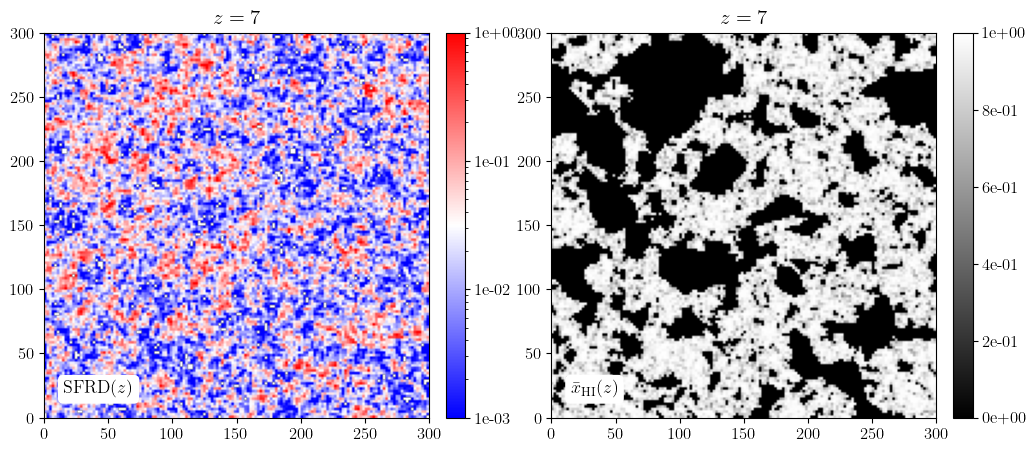

In [11]:
z = 7.
zid = min(range(len(zvals)), key=lambda i: np.abs((zvals[i]-z))) 
_islice = 0 # which slice to plot


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

im = ax[0].imshow(slice_SFRD[zid][_islice], extent=(0,Lbox_fid,0,Lbox_fid),cmap=cmap[0],norm = LogNorm(vmax =vmax[0], vmin = vmin[0]))
fig.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04, format="%.0e")

ax[0].text(
    0.05, 0.05, r'${\rm SFRD}(z)$', 
    color='black',
    fontsize=13,
    ha='left', va='bottom',
    transform=ax[0].transAxes,  
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  
)
xticks = [1e-3, 1e-2, 1e-1,1]  
array_ticks = np.vectorize(lambda x: f"{x:.0e}")(xticks)
ax[0].set_title(r'$z=%g$'%z)

im = ax[1].imshow(slice_xH[zid][_islice], extent=(0,Lbox_fid,0,Lbox_fid),cmap=cmap[1],vmax =vmax[1], vmin = vmin[1])
fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04, format="%.0e")

ax[1].text(
    0.05, 0.05, r'$\bar{x}_{\rm HI}(z)$', 
    color='black',
    fontsize=13,
    ha='left', va='bottom',
    transform=ax[1].transAxes,  
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  
)
xticks = np.linspace(vmin[1],vmax[1],4)
array_ticks = np.vectorize(lambda x: f"{x:.0e}")(xticks)

ax[1].set_title(r'$z=%g$'%z)


Interpolate the 2 point coefficient to get it redshift and scale dependent 

In [12]:
r_SFRDxH_funct = RegularGridInterpolator((zvals, temp[1]), r_SFRDxH, bounds_error=False, fill_value=0.)

Get z as function of xH (neutral fraction!) by interpolating 

In [44]:
z_of_xH = interp1d(xHvals, zvals, bounds_error=False, fill_value=0.)

In [21]:
kvals = [0.1,0.3,0.5,1] # scales to plot
color_k = [a.colors[0],a.colors[2],a.colors[5],a.colors[-1]] # colors for plot

xHreq = [0.5,0.05,0.01] # ionized hydrogen fractions to plot
ls_xH = [':','--','-'] # linestyle for plot

Text(0.5, 0.98, '${\\rm SFRD}\\times x_{\\rm H}$')

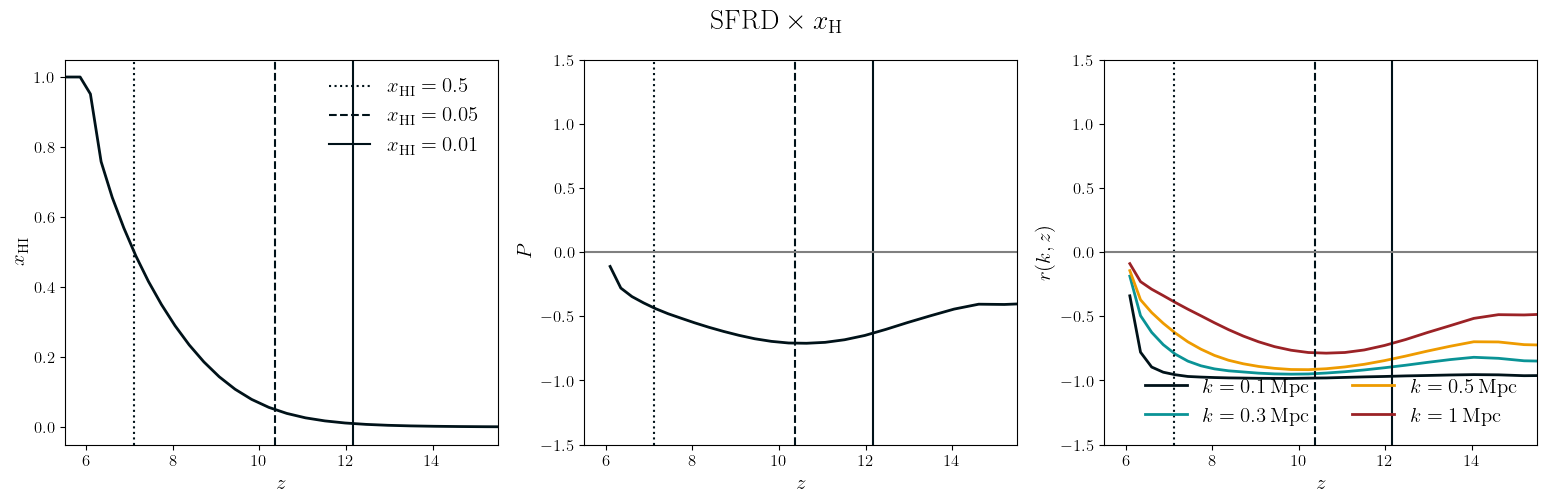

In [15]:
plt.figure(figsize=(19,5))

plt.subplot(131)
plt.plot(zvals,1.-xHvals,color=a.colors[0])
for xHi in xHreq:
    # we plot the ionized fraction but redshift interpolates over the neutral fraction = 1 - ionized
    plt.axvline(z_of_xH(1-xHi), linewidth=1.5,color=a.colors[0],ls=ls_xH[xHreq.index(xHi)], label=r'$x_{\rm HI}=%g$'%(xHi))
plt.xlim(5.5,15.5)
plt.xlabel(r'$z$')
plt.ylabel(r'$x_{\rm HI}$')
plt.legend(loc=1,ncol=1)

plt.subplot(132)
plt.plot(zvals,P_SFRDxH,color=a.colors[0])
for xHi in xHreq:
    # we plot the ionized fraction but redshift interpolates over the neutral fraction = 1 - ionized
    plt.axvline(z_of_xH(1-xHi), linewidth=1.5,color=a.colors[0],ls=ls_xH[xHreq.index(xHi)], label=r'$x_{\rm HI}=%g$'%(xHi))
plt.axhline(0.,linewidth=1.5,color= 'gray')
plt.xlim(5.5,15.5)
plt.xlabel(r'$z$')
plt.ylabel(r'$P$')
plt.ylim(-1.5,1.5)

plt.subplot(133)
for kv in kvals:
    points = np.column_stack([zvals, np.full_like(zvals, kv)])
    plt.plot(zvals,r_SFRDxH_funct(points),label=r'$k=%g\,{\rm Mpc}$'%kv,color=color_k[kvals.index(kv)])
for xHi in xHreq:
    # we plot the ionized fraction but redshift interpolates over the neutral fraction = 1 - ionized
    plt.axvline(z_of_xH(1-xHi), linewidth=1.5,color=a.colors[0],ls=ls_xH[xHreq.index(xHi)],)
plt.axhline(0.,linewidth=1.5, color='gray')
plt.xlabel(r'$z$')
plt.ylabel(r'$r(k,z)$')
plt.legend(loc=4,ncol=2)
plt.ylim(-1.5,1.5)
plt.xlim(5.5,15.5)

plt.suptitle(r'${\rm SFRD}\times x_{\rm H}$', fontsize=20)


## Get correlation between line and 21cm

Default will take around 8m

In [16]:
r_21line = np.zeros((len(zvals),len(k_bins)-1))
P_21line = np.zeros(len(zvals))
r_21line_noshot = np.zeros((len(zvals),len(k_bins)-1))
P_21line_noshot = np.zeros(len(zvals))

# !!! TO FIX !!! 
Nbins = 100 
CC_21line = np.zeros((len(zvals),(Nbins-1), (Nbins-1)))
CC_21line_noshot = np.zeros((len(zvals),(Nbins-1), (Nbins-1)))
conj_line = []
conj_line_noshot = []
conj_21 = []

xHvals = np.zeros(len(zvals))
slice_line = []
pk_line = []
slice_line_noshot = []
pk_line_noshot = []
slice_21 = []
pk_21 = []
slice_21_only = []
pk_21_only = []

for i in tqdm(range(len(zvals))):

    boxes, cmap, title, vmin, vmax, xHavg = get_boxes(zvals[i], Lbox_fid, Nbox_fid, line_model, reionization_map_partial, ion_frac_withpartial, ClassyC, RSD_MODE, None, seed, extralabel='', save=False)

    slice_21.append(boxes[0])
    slice_21_only.append(boxes[1])
    slice_line.append(boxes[3])
    slice_line_noshot.append(boxes[2])

    temp_1 = r_cross(slice_line[i], slice_21[i], Lbox_fid, k_bins, foregrounds=False)
    r_21line[i,:] = temp_1[0]
    P_21line[i] = Pearson(slice_line[i], slice_21[i], foregrounds=False)

    pk_line.append(temp_1[-1])
    pk_21.append(temp_1[-2])

    temp_2 = r_cross(slice_line_noshot[i], slice_21_only[i], Lbox_fid, k_bins, foregrounds=False)

    pk_line_noshot.append(temp_2[-1])
    pk_21_only.append(temp_2[-2])

    temp_3 = r_cross(slice_line_noshot[i], slice_21[i], Lbox_fid, k_bins, foregrounds=False)
    r_21line_noshot[i,:] = temp_3[0]
    P_21line_noshot[i] = Pearson(slice_line_noshot[i], slice_21[i], foregrounds=False)

    temp_1pt = CC_estimator(slice_line[i], slice_21[i], Nbins)
    CC_21line[i,:,:] = temp_1pt[0] 
    conj_line.append(temp_1pt[1])
    conj_21.append(temp_1pt[2])

    temp_1pt_sn = CC_estimator(slice_line_noshot[i], slice_21[i], Nbins)
    CC_21line_noshot[i,:,:] = temp_1pt_sn[0] 
    conj_line_noshot.append(temp_1pt_sn[1])

    xHvals[i] = xHavg

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_215395/291204569.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  CC_21line[i,:,:] = temp_1pt[0]
/tmp/ipykernel_215395/291204569.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  CC_21line_noshot[i,:,:] = temp_1pt_sn[0]
100%|██████████| 50/50 [11:59<00:00, 14.39s/it]


Plot slices

Text(0.5, 1.0, '$z=7$')

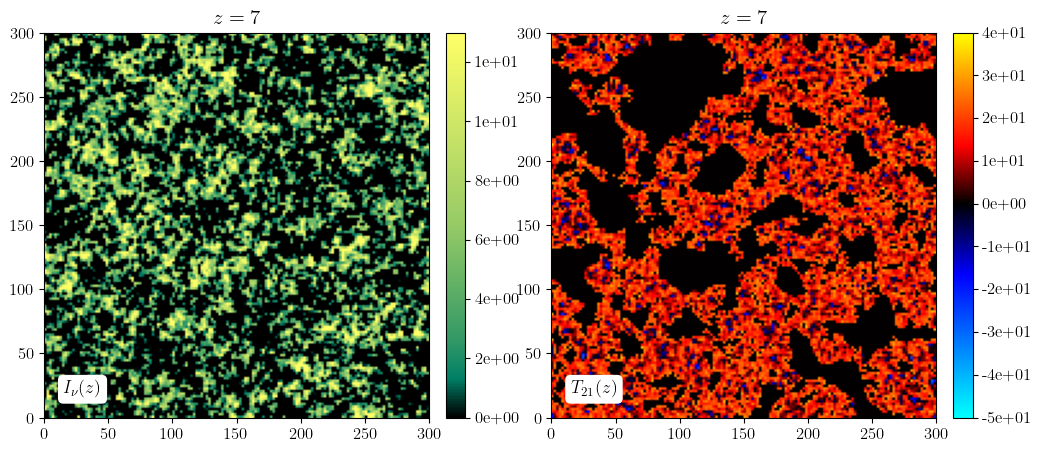

In [17]:
z_1 = 7.
zid_1 = min(range(len(zvals)), key=lambda i: np.abs((zvals[i]-z_1))) 

_islice = 0 # which slice to plot

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

im = ax[0].imshow(slice_line[zid_1][_islice], extent=(0,Lbox_fid,0,Lbox_fid),cmap=cmap[-1],vmax =13, vmin = vmin[-1])
fig.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04, format="%.0e")

ax[0].text(
    0.05, 0.05, r'$I_{\nu}(z)$', 
    color='black',
    fontsize=13,
    ha='left', va='bottom',
    transform=ax[0].transAxes,  
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  
)
ax[0].set_title(r'$z=%g$'%z_1)
xticks = np.linspace(vmin[-1],vmax[-1],4)
array_ticks = np.vectorize(lambda x: f"{x:.0e}")(xticks)

im = ax[1].imshow(slice_21[zid_1][_islice], extent=(0,Lbox_fid,0,Lbox_fid),cmap=cmap[0],vmax =vmax[0], vmin = vmin[0])
fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04, format="%.0e")

ax[1].text(
    0.05, 0.05, r'$T_{21}(z)$', 
    color='black',
    fontsize=13,
    ha='left', va='bottom',
    transform=ax[1].transAxes,  
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  
)
xticks = np.linspace(vmin[0],vmax[0],4)
array_ticks = np.vectorize(lambda x: f"{x:.0e}")(xticks)

ax[1].set_title(r'$z=%g$'%z_1)


Interpolate the 2 point coefficient to get it redshift and scale dependent 

In [18]:
r_21line_funct = RegularGridInterpolator((zvals, temp_1[1]), r_21line, bounds_error=False, fill_value=0.)
r_21line_noshot_funct = RegularGridInterpolator((zvals, temp_1[1]), r_21line_noshot, bounds_error=False, fill_value=0.)

Get z as function of xH (neutral fraction!) by interpolating 


In [19]:
z_of_xH = interp1d(xHvals, zvals, bounds_error=False, fill_value=0.)

Text(0.5, 0.98, '${\\rm OIII}$$\\times 21{\\rm cm}$')

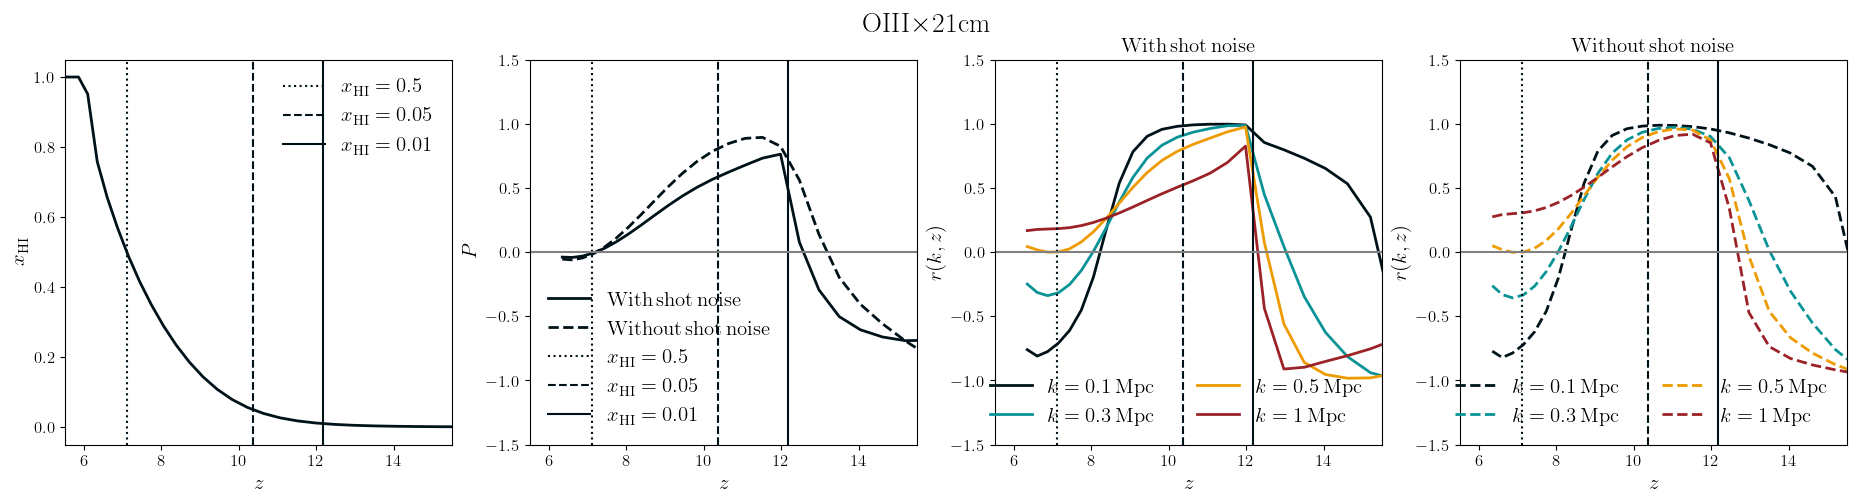

In [25]:
plt.figure(figsize=(23,5))

plt.subplot(141)
plt.plot(zvals,1.-xHvals,color=a.colors[0])
for xHi in xHreq:
    # we plot the ionized fraction but redshift interpolates over the neutral fraction = 1 - ionized
    plt.axvline(z_of_xH(1-xHi), linewidth=1.5,color=a.colors[0],ls=ls_xH[xHreq.index(xHi)], label=r'$x_{\rm HI}=%g$'%(xHi))
plt.xlim(5.5,15.5)
plt.xlabel(r'$z$')
plt.ylabel(r'$x_{\rm HI}$')
plt.legend(loc=1,ncol=1)

plt.subplot(142)
plt.plot(zvals,P_21line,color=a.colors[0],label=r'$\rm With\,shot\,noise$')
plt.plot(zvals,P_21line_noshot,color=a.colors[0],ls='--',label=r'$\rm Without\,shot\,noise$')
for xHi in xHreq:
    # we plot the ionized fraction but redshift interpolates over the neutral fraction = 1 - ionized
    plt.axvline(z_of_xH(1-xHi), linewidth=1.5,color=a.colors[0],ls=ls_xH[xHreq.index(xHi)], label=r'$x_{\rm HI}=%g$'%(xHi))
plt.axhline(0.,linewidth=1.5,color= 'gray')
plt.xlim(5.5,15.5)
plt.xlabel(r'$z$')
plt.ylabel(r'$P$')
plt.ylim(-1.5,1.5)
plt.legend(loc=3,ncol=1)

plt.subplot(143)
for kv in kvals:
    points = np.column_stack([zvals, np.full_like(zvals, kv)])
    plt.plot(zvals,r_21line_funct(points),label=r'$k=%g\,{\rm Mpc}$'%kv,color=color_k[kvals.index(kv)])
for xHi in xHreq:
    # we plot the ionized fraction but redshift interpolates over the neutral fraction = 1 - ionized
    plt.axvline(z_of_xH(1-xHi), linewidth=1.5,color=a.colors[0],ls=ls_xH[xHreq.index(xHi)],)
plt.axhline(0.,linewidth=1.5, color='gray')
plt.xlabel(r'$z$')
plt.ylabel(r'$r(k,z)$')
plt.legend(loc=4,ncol=2)
plt.ylim(-1.5,1.5)
plt.xlim(5.5,15.5)
plt.title(r'$\rm With\,shot\,noise$')

plt.subplot(144)
for kv in kvals:
    points = np.column_stack([zvals, np.full_like(zvals, kv)])
    plt.plot(zvals,r_21line_noshot_funct(points),label=r'$k=%g\,{\rm Mpc}$'%kv,color=color_k[kvals.index(kv)],ls='--')
for xHi in xHreq:
    # we plot the ionized fraction but redshift interpolates over the neutral fraction = 1 - ionized
    plt.axvline(z_of_xH(1-xHi), linewidth=1.5,color=a.colors[0],ls=ls_xH[xHreq.index(xHi)],)
plt.axhline(0.,linewidth=1.5, color='gray')
plt.xlabel(r'$z$')
plt.ylabel(r'$r(k,z)$')
plt.legend(loc=4,ncol=2)
plt.ylim(-1.5,1.5)
plt.title(r'$\rm Without\,shot\,noise$')
plt.xlim(5.5,15.5)

plt.suptitle(r'${\rm %s}$'%line_model.LP.LINE+r'$\times 21{\rm cm}$', fontsize=20)


Characteristic function plot

In [43]:
# !!! TO FIX !!! 

Interpolate and plot power spectra, boxes vs analytical

In [21]:
pk_21_funct = RegularGridInterpolator((zvals, temp_1[1]), pk_21, bounds_error=False, fill_value=0.)
pk_21_only_funct = RegularGridInterpolator((zvals, temp_1[1]), pk_21_only, bounds_error=False, fill_value=0.)
pk_line_funct = RegularGridInterpolator((zvals, temp_1[1]), pk_line, bounds_error=False, fill_value=0.)
pk_line_noshot_funct = RegularGridInterpolator((zvals, temp_1[1]), pk_line_noshot, bounds_error=False, fill_value=0.)

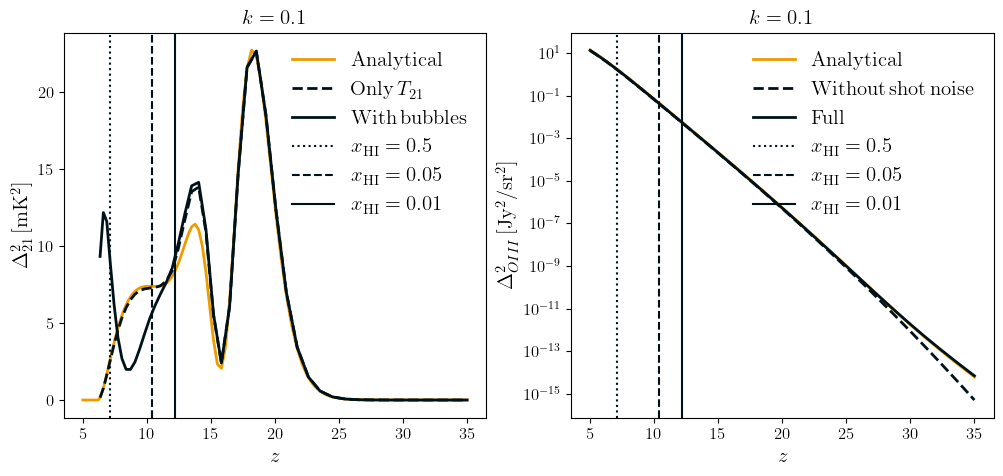

In [56]:
plt.figure(figsize=(12,5))

kv = 0.1
kid_analytical = min(range(len(line_model.LIM_corr._klistCF)), key=lambda i: np.abs((line_model.LIM_corr._klistCF[i]-kv)))
kid = min(range(len(temp_1[1])), key=lambda i: np.abs((temp_1[1][i]-kv))) 


plt.subplot(121)
k32pi = kv**3/2/np.pi**2
points = np.column_stack([zvals,np.full_like(zvals, kv)])
plt.plot(line_model.zeus_coeff.zintegral,line_model.zeus_pk.Deltasq_T21[:,kid_analytical],label=r'${\rm Analytical}$',color=a.colors[5])
plt.plot(zvals,pk_21_only_funct(points)*k32pi,label=r'${\rm Only}\, T_{21}$',color=a.colors[0],ls='--')
plt.plot(zvals,pk_21_funct(points)*k32pi,label=r'${\rm With\, bubbles}$',color=a.colors[0])
for xHi in xHreq:
    # we plot the ionized fraction but redshift interpolates over the neutral fraction = 1 - ionized
    plt.axvline(z_of_xH(1-xHi), linewidth=1.5,color=a.colors[0],ls=ls_xH[xHreq.index(xHi)], label=r'$x_{\rm HI}=%g$'%(xHi))

plt.title(r'$k=%g$'%kv)
plt.ylabel(r'$\Delta^2_{21}\,[\rm mK^2]$')
plt.xlabel(r'$z$')
plt.legend(loc=1)

plt.subplot(122)
plt.semilogy(line_model.zeus_coeff.zintegral,line_model.LIM_pk._Pk_LIM_tot[:,kid_analytical]*line_model.LIM_corr._klistCF[kid_analytical]**3/2/np.pi**2,label=r'${\rm Analytical}$',color=a.colors[5])
plt.semilogy(zvals,pk_line_noshot_funct(points)*k32pi,label=r'${\rm Without\,shot\,noise}$',color=a.colors[0],ls='--')
plt.semilogy(zvals,pk_line_funct(points)*k32pi,label=r'${\rm Full}$',color=a.colors[0])
for xHi in xHreq:
    # we plot the ionized fraction but redshift interpolates over the neutral fraction = 1 - ionized
    plt.axvline(z_of_xH(1-xHi), linewidth=1.5,color=a.colors[0],ls=ls_xH[xHreq.index(xHi)], label=r'$x_{\rm HI}=%g$'%(xHi))

plt.title(r'$k=%g$'%kv)
plt.ylabel(r'$\Delta^2_{%s}\,[\rm Jy^2/sr^2]$'%line_model.LP.LINE)
plt.xlabel(r'$z$')
plt.legend(loc=1)


## Now we study how things change varying the parameters

1) First we re-define the classes containing the fiducial parameters for the oLIMpus run 

In [6]:
# user parameters
UP = a.User_Parameters(
            precisionboost= 1.0, 
            FLAG_FORCE_LINEAR_CF= 0, 
            MIN_R_NONLINEAR= 0.5, 
            MAX_R_NONLINEAR= 200.0,
            FLAG_DO_DENS_NL= False, 
            FLAG_WF_ITERATIVE= True,
            )

# cosmological parameters
CP, ClassyC, zeus_corr, HMFcl = a.cosmo_wrapper(UP, a.Cosmo_Parameters_Input(**a.CosmoParams_input_fid))

# line parameters
LineParams_Input_val = a.LineParams_Input(
            LINE = 'OIII', # which line
            LINE_MODEL = 'Yang24', # model of the line luminosity
            OBSERVABLE_LIM = 'Inu', # observe intensity in Jy/sr or mK
            _R = 1., # resolution for smoothing
            sigma_LMh = 0., # stochasticity in the L-SFR relation
            shot_noise = True, # add shot noise to the power spectrum
            quadratic_lognormal = True # use 1st or 2nd order in the SFRD and line lognormal approximation MOVE TO USER PARAMS
        )
LP = a.Line_Parameters(LineParams_Input_val,UP)

2) We define the astrophysical parameters through a function that can be used to update them 

In [7]:
def change_astro(alphastar,betastar,epsstar,Mturn_fixed,Mc,fesc):

    AstroParams_input = copy(a.AstroParams_input_fid)
    if alphastar is not None:
        AstroParams_input['alphastar'] = alphastar
    if betastar is not None:
        AstroParams_input['betastar'] = betastar
    if epsstar is not None:
        AstroParams_input['epsstar'] = epsstar
    if Mturn_fixed is not None:
        AstroParams_input['Mturn_fixed'] = Mturn_fixed
    if Mc is not None:
        AstroParams_input['Mc'] = Mc
    if fesc is not None:
        AstroParams_input['fesc10'] = fesc
        
    AP = a.zeus21.Astro_Parameters(UP, CP, **AstroParams_input)
    
    return AP

3) We define the function to run the LIM and 21cm power spectra with the updated parameters

In [8]:
def run_LIM(alphastar,betastar,epsstar,Mturn_fixed,Mc,fesc):

    AP = change_astro(alphastar,betastar,epsstar,Mturn_fixed,Mc,fesc)

    # LIM
    LIM_coeff = a.get_LIM_coefficients(LP, AP, CP, HMFcl, UP, ZMIN)

    LIM_corr = a.Correlations_LIM(LP, CP, ClassyC)

    LIM_pk = a.Power_Spectra_LIM(LIM_corr, LIM_coeff, LP, CP, UP, RSD_MODE)

    # power spectra 
    zeus_coeff = get_T21_coefficients(UP, CP, ClassyC, AP, HMFcl, ZMIN)

    zeus_corr = Correlations(UP, CP, ClassyC)

    zeus_pk = Power_Spectra(UP, CP, AP, ClassyC, zeus_corr, zeus_coeff, RSD_MODE)

    return AP, LIM_coeff, LIM_corr, LIM_pk, zeus_coeff, zeus_corr, zeus_pk

3) Let's study two cases, in which we change respectively the SFR efficiency and the escape fraction

In [9]:
epsstar_model = lambda epsstar: run_LIM(alphastar=None,betastar=None,epsstar=epsstar,Mturn_fixed=None,Mc=None,fesc=None)
fesc_model = lambda fesc: run_LIM(alphastar=None,betastar=None,epsstar=None,Mturn_fixed=None,Mc=None,fesc=fesc)

In [10]:
# values
epsstar_val = np.logspace(-2,np.log10(0.5),5)
fesc_val = np.logspace(-2,np.log10(0.5),5)
colors=[a.colors[2],a.colors[3],a.colors[4],a.colors[5],a.colors[6]]

In [11]:
Lbox_fid = 300 # box side Mpc
Nbox_fid = 50 # number of cells per side
seed = 3 # random seed

zvals = np.logspace(np.log10(5), np.log10(30),50) # z array 
k_bins = np.logspace(np.log10(2*np.pi/Lbox_fid),np.log10(2*np.pi/Lbox_fid*Nbox_fid),10) # k array 

In [21]:
r_v_OIII_kv = []
xHv = []
pk_kv = []
p = []

fesc_r_v_OIII_kv = []
fesc_xHv = []
fesc_pk_kv = []
fesc_p = []

kv = 0.1 # which k to plot 
with_shotnoise = True

for i in tqdm(range(len(epsstar_val))):
    AP, LIM_coeff, LIM_corr, LIM_pk, zeus_coeff, zeus_corr, zeus_pk = epsstar_model(epsstar_val[i])

    r_v_OIII_kv.append(np.zeros((len(zvals))))
    xHv.append(np.zeros((len(zvals))))
    pk_kv.append(np.zeros((len(zvals))))
    p.append(np.zeros((len(zvals))))

    reionization_map_partial, ion_frac_withpartial = get_reio_field(zeus_coeff, zeus_corr, AP, CP, ClassyC, HMFcl, Lbox_fid, Nbox_fid, mass_weighted_xHII=True, seed=seed)

    for zv in tqdm(range(len(zvals))):

        box_line_all = CoevalBox_LIM_analytical(LIM_coeff,LIM_corr,LIM_pk,LP,zvals[zv],LP._R,Lbox_fid,Nbox_fid, RSD=RSD_MODE, get_density_box=True,seed=seed,one_slice=False)

        if with_shotnoise:
            box_line = box_line_all.Inu_box_smooth
        else:
            box_line = box_line_all.Inu_box_noiseless_smooth

        box_T21 = CoevalBox_T21reionization(zeus_coeff, zeus_pk,zvals[zv], reionization_map_partial, ion_frac_withpartial,Lbox_fid,Nbox_fid,seed=seed,one_slice=False)

        xHv[i][zv] = box_T21.xH_avg_map

        temp_v = r_cross(box_line,box_T21.T21_map, Lbox_fid, k_bins, foregrounds=False)

        intrep_rv = interp1d(temp_v[1],temp_v[0],kind='linear')
        intrep_pk = interp1d(temp_v[1],temp_v[-2],kind='linear')

        r_v_OIII_kv[i][zv] = intrep_rv(kv)

        pk_kv[i][zv]= intrep_pk(kv)

        p[i][zv] = Pearson(box_line,box_T21.T21_map,False)


for i in tqdm(range(len(fesc_val))):

    AP, LIM_coeff, LIM_corr, LIM_pk, zeus_coeff, zeus_corr, zeus_pk = fesc_model(fesc_val[i])

    fesc_r_v_OIII_kv.append(np.zeros((len(zvals))))
    fesc_xHv.append(np.zeros((len(zvals))))
    fesc_pk_kv.append(np.zeros((len(zvals))))
    fesc_p.append(np.zeros((len(zvals))))

    reionization_map_partial, ion_frac_withpartial = get_reio_field(zeus_coeff, zeus_corr, AP, CP, ClassyC, HMFcl, Lbox_fid, Nbox_fid, mass_weighted_xHII=True, seed=seed)

    for zv in tqdm(range(len(zvals))):

        box_line_all = CoevalBox_LIM_analytical(LIM_coeff,LIM_corr,LIM_pk,LP,zvals[zv],LP._R,Lbox_fid,Nbox_fid, RSD=RSD_MODE, get_density_box=True,seed=seed,one_slice=False)

        if with_shotnoise:
            box_line = box_line_all.Inu_box_smooth
        else:
            box_line = box_line_all.Inu_box_noiseless_smooth

        box_T21 = CoevalBox_T21reionization(zeus_coeff, zeus_pk,zvals[zv], reionization_map_partial, ion_frac_withpartial,Lbox_fid,Nbox_fid,seed=seed,one_slice=False)

        fesc_xHv[i][zv] = box_T21.xH_avg_map

        temp_v = r_cross(box_line,box_T21.T21_map, Lbox_fid, k_bins, foregrounds=False)

        intrep_rv = interp1d(temp_v[1],temp_v[0],kind='linear')
        intrep_pk = interp1d(temp_v[1],temp_v[-2],kind='linear')

        intrep_rv = interp1d(temp_v[1],temp_v[0],kind='linear')
        intrep_pk = interp1d(temp_v[1],temp_v[-2],kind='linear')

        fesc_r_v_OIII_kv[i][zv] = intrep_rv(kv)

        fesc_pk_kv[i][zv]= intrep_pk(kv)

        fesc_p[i][zv] = Pearson(box_line,box_T21.T21_map,False)


  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:00<00:01,  5.52it/s]


SUCCESS: BMF converged in 4 iterations.


100%|██████████| 99/99 [00:01<00:00, 82.70it/s]


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


 50%|█████     | 5/10 [00:01<00:01,  4.92it/s]


SUCCESS: BMF converged in 5 iterations.


100%|██████████| 99/99 [00:01<00:00, 77.03it/s]


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


 60%|██████    | 6/10 [00:00<00:00,  6.07it/s]


SUCCESS: BMF converged in 6 iterations.


100%|██████████| 99/99 [00:01<00:00, 63.76it/s]


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/zeus21_local/zeus21/maps.py:97: RuntimeWarning: invalid value encountered in divide
  lognormpower = interp1d(klist,excesspower21/self.T21global**2,fill_value=0.0,bounds_error=False)


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


 60%|██████    | 6/10 [00:01<00:00,  5.59it/s]


SUCCESS: BMF converged in 6 iterations.


100%|██████████| 99/99 [00:01<00:00, 77.76it/s]


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


 60%|██████    | 6/10 [00:01<00:00,  5.05it/s]

SUCCESS: BMF converged in 6 iterations.



100%|██████████| 99/99 [00:01<00:00, 82.85it/s]


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


 40%|████      | 4/10 [00:00<00:00,  6.28it/s]


SUCCESS: BMF converged in 4 iterations.


100%|██████████| 99/99 [00:01<00:00, 85.38it/s]


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


 50%|█████     | 5/10 [00:00<00:00,  5.72it/s]


SUCCESS: BMF converged in 5 iterations.


100%|██████████| 99/99 [00:01<00:00, 71.97it/s]


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


 60%|██████    | 6/10 [00:01<00:00,  4.67it/s]


SUCCESS: BMF converged in 6 iterations.


100%|██████████| 99/99 [00:01<00:00, 90.41it/s]


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


 60%|██████    | 6/10 [00:01<00:00,  5.56it/s]


SUCCESS: BMF converged in 6 iterations.


100%|██████████| 99/99 [00:01<00:00, 68.86it/s]


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


 60%|██████    | 6/10 [00:01<00:00,  5.50it/s]


SUCCESS: BMF converged in 6 iterations.


100%|██████████| 99/99 [00:01<00:00, 75.76it/s]


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 6.0


100%|██████████| 5/5 [03:08<00:00, 37.75s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 106.52it/s]


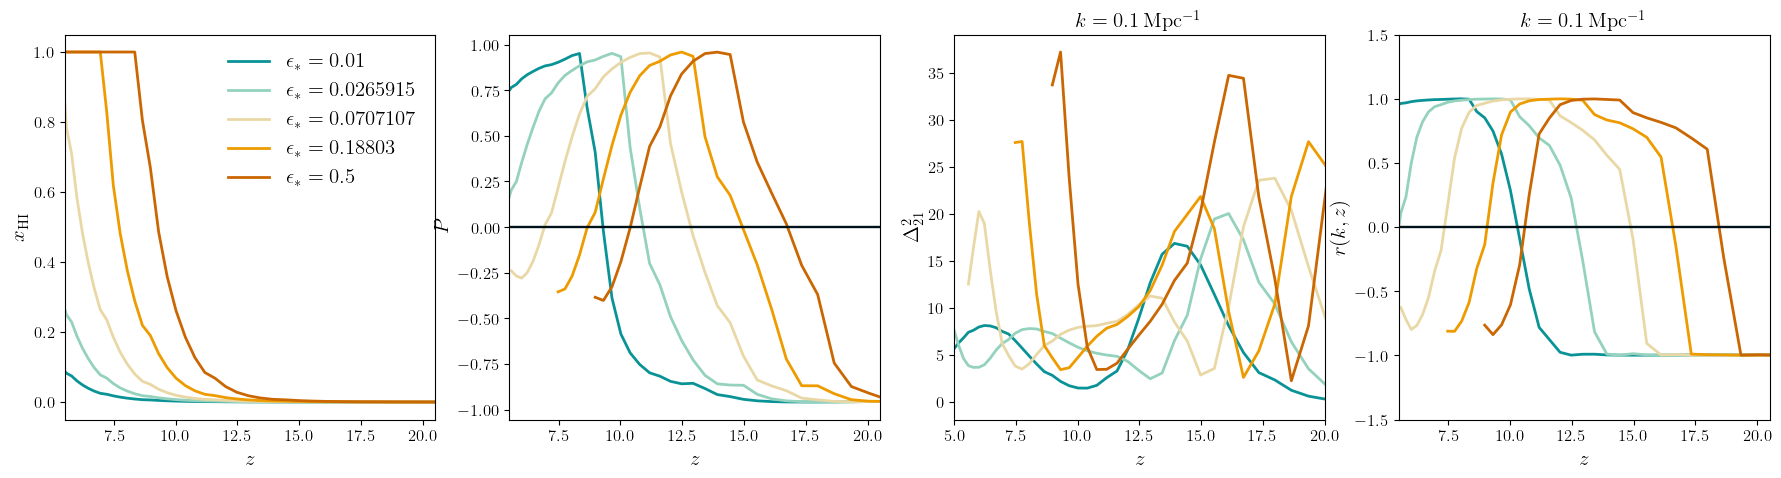

100%|██████████| 5/5 [00:00<00:00, 109.96it/s]


Text(0, 0.5, '$P$')

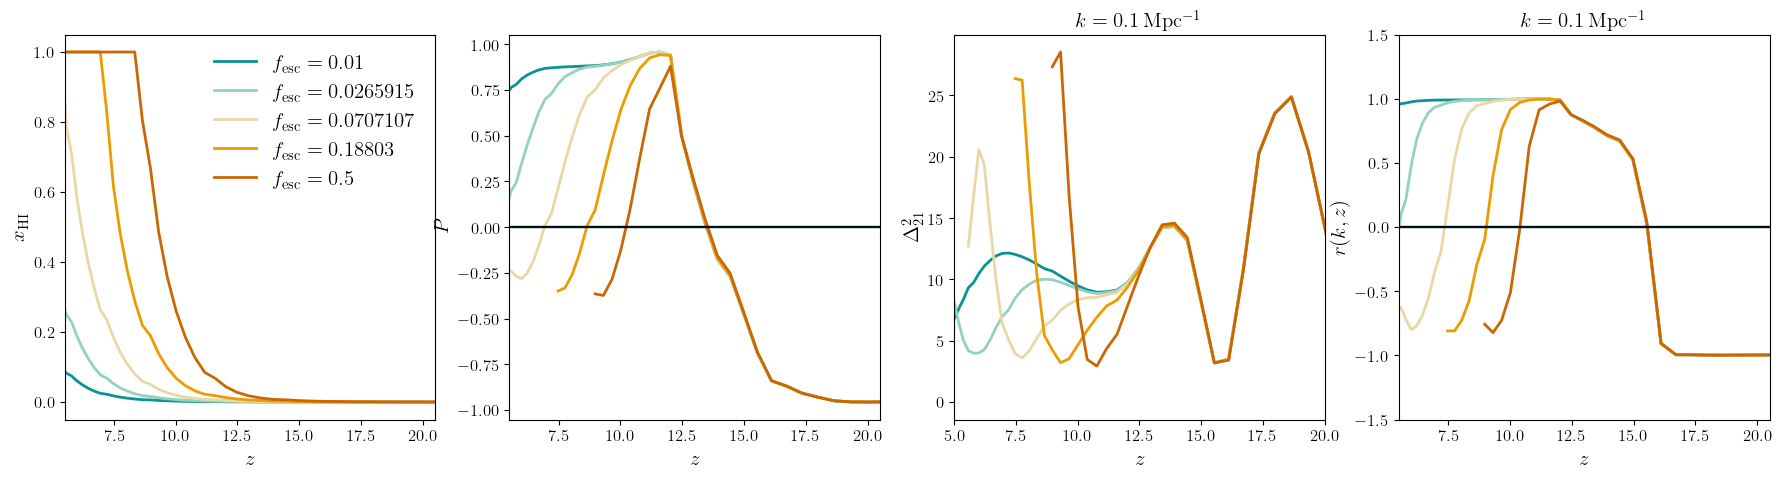

In [26]:
plt.figure(figsize=(22,5))
for i in tqdm(range(len(epsstar_val))):

    plt.subplot(141)
    plt.plot(zvals,1-xHv[i],color=colors[i], label=r'$\epsilon_*=%g$'%epsstar_val[i])

    plt.subplot(142)
    plt.plot(zvals,p[i],color=colors[i])

    plt.subplot(143)
    plt.plot(zvals,pk_kv[i]*kv**3/2./np.pi**2,a.colors[0],label=r'$k=%s\,{\rm Mpc}$'%kv,color=colors[i])

    plt.subplot(144)
    plt.plot(zvals,r_v_OIII_kv[i],label=r'$k=%s\,{\rm Mpc}$'%kv,color=colors[i])


plt.subplot(144)
plt.axhline(0.,linewidth=1.7)
plt.xlabel(r'$z$')
plt.ylabel(r'$r(k,z)$')
plt.ylim(-1.5,1.5)
plt.xlim(5.5,20.5)
plt.title(r'$k=%g\,{\rm Mpc^{-1}}$'%kv)

plt.subplot(143)
plt.xlim(5,20)
plt.xlabel(r'$z$')
plt.ylabel(r'$\Delta^2_{21}$')
plt.title(r'$k=%g\,{\rm Mpc^{-1}}$'%kv)

plt.subplot(141)
plt.legend(loc=1)
plt.xlim(5.5,20.5)
plt.xlabel(r'$z$')
plt.ylabel(r'$x_{\rm HI}$')

plt.subplot(142)
plt.axhline(0.,linewidth=1.7)
plt.xlim(5.5,20.5)
plt.xlabel(r'$z$')
plt.ylabel(r'$P$')

plt.show()

plt.figure(figsize=(22,5))
for i in tqdm(range(len(fesc_val))):

    plt.subplot(141)
    plt.plot(zvals,1-fesc_xHv[i],color=colors[i], label=r'$f_{\rm esc}=%g$'%fesc_val[i])

    plt.subplot(142)
    plt.plot(zvals,fesc_p[i],color=colors[i])

    plt.subplot(143)
    plt.plot(zvals,fesc_pk_kv[i]*kv**3/2./np.pi**2,a.colors[0],label=r'$k=%s\,{\rm Mpc}$'%kv,color=colors[i])

    plt.subplot(144)
    plt.plot(zvals,fesc_r_v_OIII_kv[i],label=r'$k=%s\,{\rm Mpc}$'%kv,color=colors[i])


plt.subplot(144)
plt.axhline(0.,linewidth=1.7)
plt.xlabel(r'$z$')
plt.ylabel(r'$r(k,z)$')
plt.ylim(-1.5,1.5)
plt.xlim(5.5,20.5)
plt.title(r'$k=%g\,{\rm Mpc^{-1}}$'%kv)

plt.subplot(143)
plt.xlim(5,20)
plt.xlabel(r'$z$')
plt.ylabel(r'$\Delta^2_{21}$')
plt.title(r'$k=%g\,{\rm Mpc^{-1}}$'%kv)

plt.subplot(141)
plt.legend(loc=1)
plt.xlim(5.5,20.5)
plt.xlabel(r'$z$')
plt.ylabel(r'$x_{\rm HI}$')


plt.subplot(142)
plt.axhline(0.,linewidth=1.7)
plt.xlim(5.5,20.5)
plt.xlabel(r'$z$')
plt.ylabel(r'$P$')
